# Open EFT file
We open the file using `NanoEventsFactory` from the `coffea` package.

In [1]:
import os
import numpy as np
import awkward as ak

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

fontsize=12
plt.style.use([hep.style.ROOT, {'font.size': fontsize}])
plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'figure.figsize' : (6, 6)})

In [2]:
fname = "/work/mmarcheg/AnalysisConfigs/configs/ttHbb/semileptonic/eft/test_eft_1.root"
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema.v6,
    #metadata=metadata,
).events()

/work/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_genPartIdx => GenPart
  warnings.warn(
/work/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/work/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/work/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/work/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index 

## Print file branches

In [3]:
events.fields

['LHE',
 'run',
 'event',
 'luminosityBlock',
 'GenVtx',
 'LHEReweightingWeight',
 'PSWeight',
 'Generator',
 'GenJetAK8',
 'LHEWeight',
 'GenJet',
 'LHEScaleWeight',
 'HTXS',
 'MET',
 'LHEPart',
 'GenMET',
 'GenIsolatedPhoton',
 'genWeight',
 'GenVisTau',
 'GenPart',
 'LHEPdfWeight',
 'GenDressedLepton']

## Print EFT reweighting weights
The EFT per-event weights are stored in the branch `LHEReweightingWeight`.

In [4]:
events.LHEReweightingWeight

<Array [[1.07, 1.13, 1, ... 1, 0.997, 0.997]] type='5000 * [var * float32[parame...'>

In [5]:
# Print the first weight, for all events
events.LHEReweightingWeight[:,0]

<Array [1.07, 1.07, 1.07, ... 1.07, 1.07, 1.07] type='5000 * float32[parameters=...'>

In [6]:
# Print the first weight, for the first event
events.LHEReweightingWeight[0,0]

1.06610107421875

## Important variables for EFT studies

The important branches are the generator level variables such as `GenJet`, `GenMET`, `GenPart`.

In [7]:
events.GenJet.pt

<Array [[132, 99.2, 81.9, ... 17.3, 14.5]] type='5000 * var * float32[parameters...'>

In [8]:
events.GenPart

<GenParticleArray [[GenParticle, ... GenParticle]] type='5000 * var * genParticle'>

In [9]:
events.GenMET

<MissingETArray [MissingET, MissingET, ... MissingET] type='5000 * missingET'>

## Select Higgs from gen particles

In [10]:
is_higgs = events.GenPart.pdgId == 25 # Select Higgs bosons from GenPart
is_higgs

<Array [[False, False, ... False, False]] type='5000 * var * bool'>

In [11]:
events.GenPart[is_higgs].fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [12]:
events.GenPart[is_higgs].hasFlags(['fromHardProcess'])

<Array [[True, True, True, ... [True, True]] type='5000 * var * bool'>

In [13]:
events.GenPart[is_higgs].childrenIdxG[0].tolist()

[[10], [32], [251], [406], [619, 620]]

In [14]:
has_children = ak.num(events.GenPart[is_higgs].childrenIdxG, axis=2) == 2 # mask to consider only the GenPart with two children (the b-quarks in the decay H->bb)
has_children

<Array [[False, False, False, ... False, True]] type='5000 * var * bool'>

In [15]:
higgs = events.GenPart[is_higgs][has_children]
higgs

<GenParticleArray [[GenParticle], ... [GenParticle]] type='5000 * var * genParticle'>

In [16]:
n_higgs = ak.num(higgs)
n_higgs

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='5000 * int64'>

In [17]:
# Check that there is one and only one Higgs boson per-event
ak.all(n_higgs == 1)

True

## Inspect Higgs variables

We can already plot some kinematical distributions of the Higgs boson at generator level.

In [18]:
higgs.pt

<Array [[64.2], [40.8], ... [238], [82.1]] type='5000 * var * float32[parameters...'>

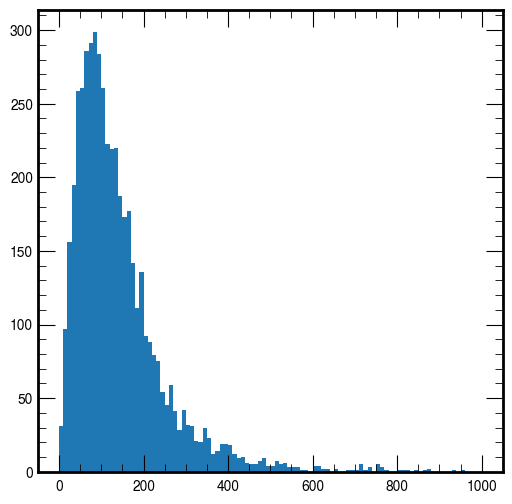

In [19]:
pt = ak.flatten(higgs.pt) # flatten the array before plotting with plt.hist()
plt.hist(pt, bins=100, range=(0, 1000));

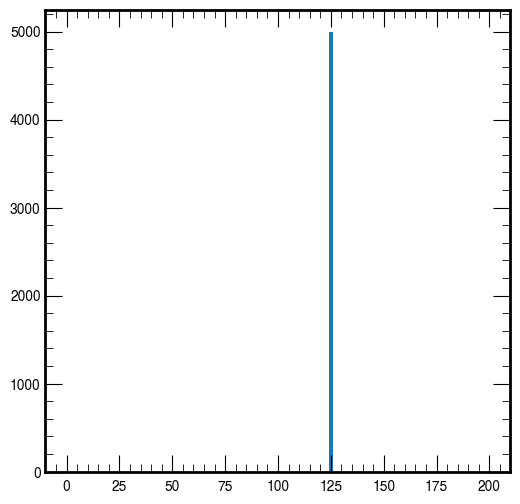

In [20]:
mass = ak.flatten(higgs.mass)
plt.hist(mass, bins=100, range=(0, 200));

## Reweigh histogram with EFT weights

We can pass the weight `events.LHEReweightingWeight` to `plt.hist()` in order to weigh the histograms with the EFT weights.

In [21]:
w0 = events.LHEReweightingWeight[:,0]
w0

<Array [1.07, 1.07, 1.07, ... 1.07, 1.07, 1.07] type='5000 * float32[parameters=...'>

## Plot of SM distribution and EFT-reweighed distribution

In order to look for EFT effects on the Higgs kinematical variables, we can plot the SM distribution and the distribution reweighed with a specific weight, to explore its on the distribution.

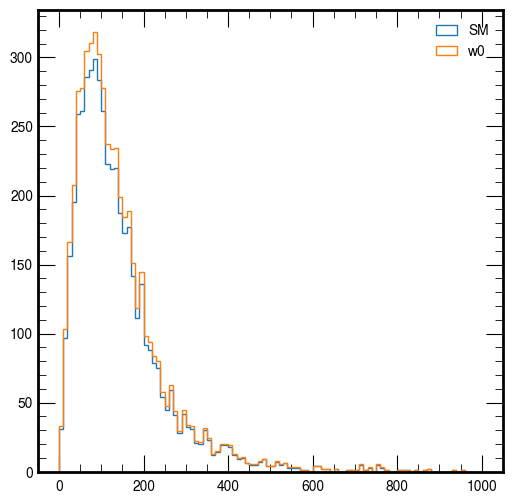

In [22]:
plt.hist(pt, bins=100, range=(0, 1000), histtype='step', label="SM")
plt.hist(pt, bins=100, range=(0, 1000), histtype='step', label="w0", weights=w0)
plt.legend();

## Inspect top variables

In [23]:
is_top = events.GenPart.pdgId == 6 # Select top quarks from GenPart
is_top

<Array [[False, False, ... False, False]] type='5000 * var * bool'>

In [24]:
has_children = ak.num(events.GenPart[is_top].childrenIdxG, axis=2) == 2 # mask to consider only the GenPart with two children
has_children

<Array [[False, False, False, ... False, True]] type='5000 * var * bool'>

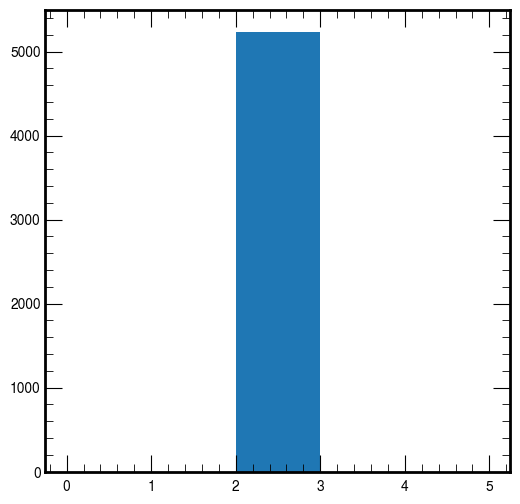

In [25]:
plt.hist(ak.flatten(ak.num(events.GenPart[is_top].childrenIdxG, axis=2)[has_children]), bins=5, range=(0,5));

In [26]:
ak.flatten(events.GenPart[is_top][has_children]).childrenIdxG[0]

<Array [593, 594] type='2 * int64'>

In [27]:
events.LHEPart.pdgId[0].tolist()

[21, 21, 4, -3, 5, 11, -12, -5, 5, -5]

In [28]:
events.GenPart[is_top].pt[0].tolist()

[178.9066162109375,
 175.6811981201172,
 175.27464294433594,
 175.47698974609375,
 175.67153930664062]